In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
import os

Prevent excessive use of GPU (if available)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

Go through all images from both categories, remove those that aren't in .jpg, .jpeg, or .png format

In [3]:
data_directory = 'images'
file_exts = ['jpg','jpeg','png']
categories = os.listdir(data_directory)

In [4]:
for category in categories:                                                  # go through 1 category of label at a time
    for image in os.listdir(os.path.join(data_directory, category)):         # gather images from selected category
        img_path = os.path.join(data_directory, category, image)             # define the image path
        ext = imghdr.what(img_path)                                          # get file extension

        if ext not in file_exts:                                             # removes images that don't meet required extension
            os.remove(img_path)
    
    print(f'No. images in {category} category: {len(os.listdir(os.path.join(data_directory, category)))}')

No. images in analogue-watch category: 215
No. images in smart-watch category: 215


Labels proportions are sufficiently balanced. Can proceed with creating dataset

In [5]:
img_data = tf.keras.utils.image_dataset_from_directory('images')    # extract the images as tensors and label accordingly
iterator = img_data.as_numpy_iterator()                             # define iterator to go through image tensors one by one
batch = iterator.next()                                             # go to next batch of images (represented still as tensors)
print(f'No. of batches: {len(img_data)}')

Found 423 files belonging to 2 classes.
No. of batches: 14


Show first 5 images as reference to how the images look like

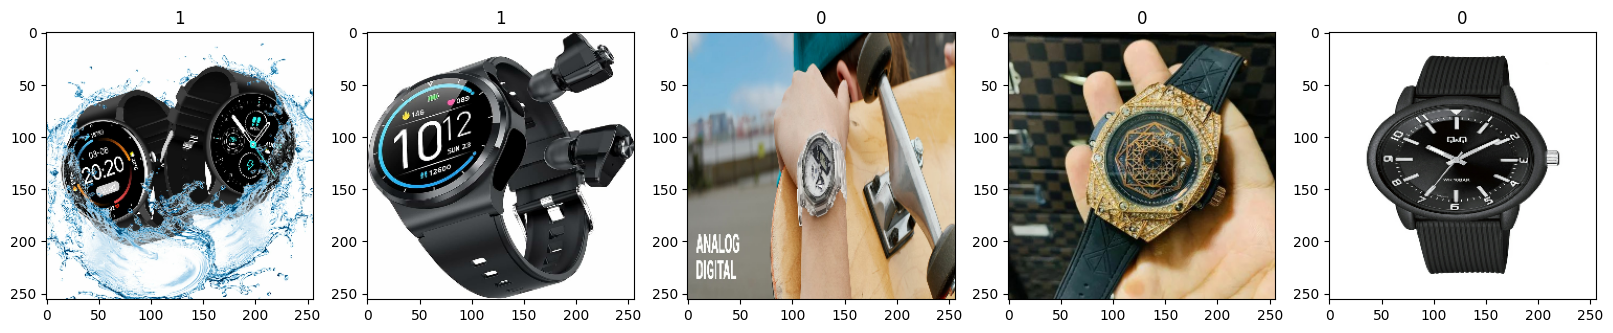

In [6]:
fig, ax = plt.subplots(ncols=5, figsize=(20,20))
for i, img in enumerate(batch[0][:5]):
    ax[i].imshow(img.astype(int))
    ax[i].title.set_text(batch[1][i])

# Label 0: analogue-watch
# Label 1: smart-watch

Rescale the data to have pixel values between 0 and 1

In [7]:
img_data = img_data.map(lambda x,y: (x/255, y))

Partition batches of images into training, validation and test sets

In [8]:
# get size of the respective data partitions
train_size = int(0.7*len(img_data)) + 1     # to balance out the number of batches
valid_size = int(0.1*len(img_data))
test_size = int(0.2*len(img_data))

In [23]:
print(train_size)
print(valid_size)
print(test_size)

10
1
2


In [9]:
train_set = img_data.take(train_size)
valid_set = img_data.skip(train_size).take(valid_size)
test_set = img_data.skip(train_size + valid_size).take(test_size)

In [27]:
print(train_set)

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Creating CNN architecture

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [11]:
## ADD LAYERS AND TEST DIFF ARCHITECTURE
cnn = Sequential()

# Convolution and Max-Pooling hidden layers
cnn.add(Conv2D(64, (3,3), 1, activation='relu', input_shape=(256,256,3)))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (3,3), 1, activation='relu'))
cnn.add(MaxPooling2D())
cnn.add(Conv2D(32, (4,4), activation='relu'))
cnn.add(MaxPooling2D())

# Flatten to convert from a tensor to numerical (2D to 1D)
cnn.add(Flatten())

# Fully-connected layer then proceed to prediction on either label 0 or 1
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(1, activation='sigmoid'))

In [12]:
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [13]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 32)        16416     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 32)       0

During training, log training history on tensorboard for model diagnostics

In [14]:
logdir = 'logs'
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

Train established CNN architecture

In [15]:
history = cnn.fit(train_set, validation_data=valid_set, epochs=30, callbacks=[tensorboard])

Epoch 1/30
10/10 [==============================] - 8s 162ms/step - loss: 0.7925 - accuracy: 0.5281 - val_loss: 0.6872 - val_accuracy: 0.4688
Epoch 2/30
10/10 [==============================] - 2s 152ms/step - loss: 0.6692 - accuracy: 0.6000 - val_loss: 0.6272 - val_accuracy: 0.7500
Epoch 3/30
10/10 [==============================] - 2s 150ms/step - loss: 0.5561 - accuracy: 0.7219 - val_loss: 0.4817 - val_accuracy: 0.7500
Epoch 4/30
10/10 [==============================] - 2s 157ms/step - loss: 0.5135 - accuracy: 0.7625 - val_loss: 0.4164 - val_accuracy: 0.8750
Epoch 5/30
10/10 [==============================] - 2s 149ms/step - loss: 0.4032 - accuracy: 0.8125 - val_loss: 0.5358 - val_accuracy: 0.7188
Epoch 6/30
10/10 [==============================] - 2s 153ms/step - loss: 0.3089 - accuracy: 0.8781 - val_loss: 0.3701 - val_accuracy: 0.8125
Epoch 7/30
10/10 [==============================] - 2s 149ms/step - loss: 0.2197 - accuracy: 0.9094 - val_loss: 0.3654 - val_accuracy: 0.8438
Epoch 

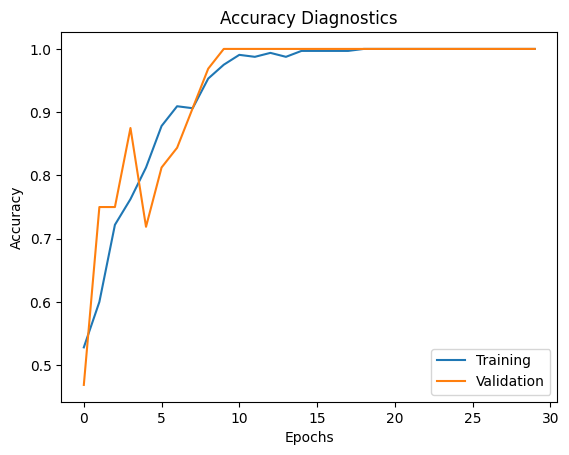

In [16]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Diagnostics')
plt.legend(loc='lower right')
plt.show()

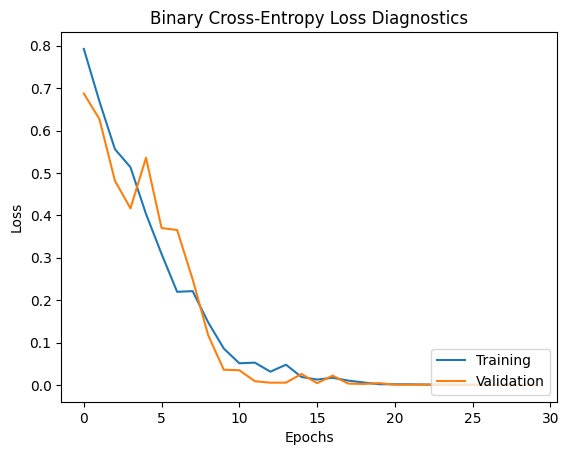

In [17]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Binary Cross-Entropy Loss Diagnostics')
plt.legend(loc='lower right')
plt.show()

Steady decrement in binary cross-entropy loss, and steady increase in accuracy. Decent performing model for prediction.

In [18]:
from tensorflow.keras.metrics import Recall, Precision


In [19]:
recall = Recall(); precision = Precision()
for batch in test_set.as_numpy_iterator():
    X, y = batch
    ypred = cnn.predict(X)

    recall.update_state(y, ypred)
    precision.update_state(y, ypred)

1/1 [==============================] - 0s 16ms/step


In [20]:
print(f'Recall: {recall.result()}\n Precision: {precision.result()}')

Recall: 1.0
 Precision: 1.0


In [21]:
test_imgs = ['test-image-4.jpg','test-image-2.jpg','test-image-3.jpg','test-image-1.jpg','test-image-5.jpg','test-image-6.jpg']

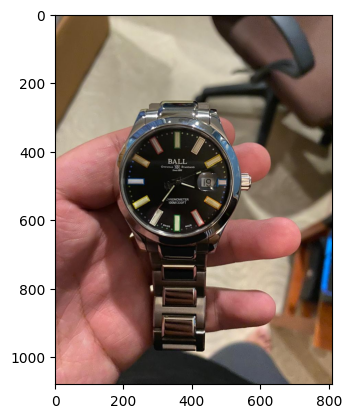

1/1 [==============================] - 0s 160ms/step
Image contains a smart watch


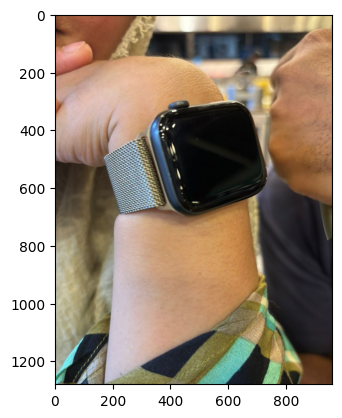

1/1 [==============================] - 0s 11ms/step
Image contains a smart watch


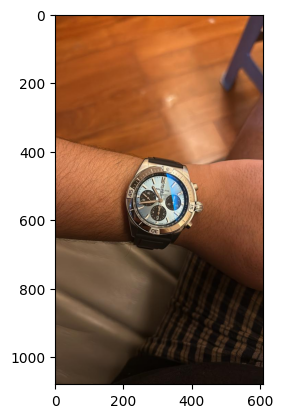

1/1 [==============================] - 0s 12ms/step
Image contains a smart watch


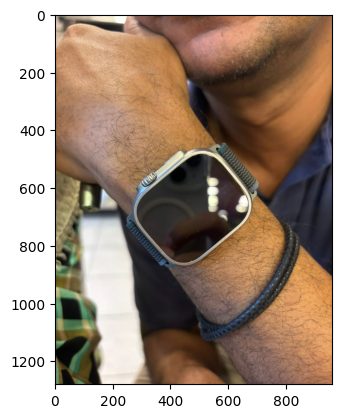

1/1 [==============================] - 0s 12ms/step
Image contains a smart watch


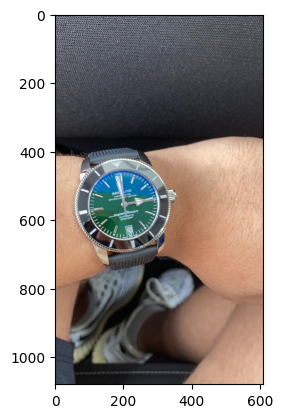

1/1 [==============================] - 0s 13ms/step
Image contains an analogue watch


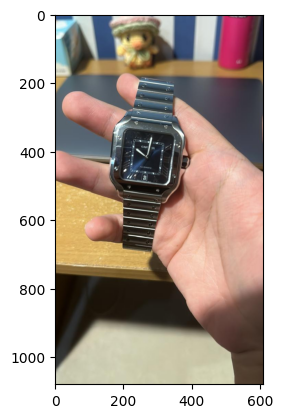

1/1 [==============================] - 0s 14ms/step
Image contains an analogue watch


In [22]:
for image in test_imgs:
    # Display images for reference and resize accordingly (256x256 pixels)
    test_img = cv2.imread(image)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.show()
    resized_img = tf.image.resize(test_img, (256,256))

    # Predict whether image is label 0 or 1
    ypred = cnn.predict(np.expand_dims(resized_img/255, 0))

    # Allocate towards label 0 or 1
    if ypred > 0.5:
        print('Image contains a smart watch')
    else:
        print('Image contains an analogue watch')


In [47]:
# Save model for future use
cnn.save(os.path.join('model','watch-CNN-V1'))

INFO:tensorflow:Assets written to: model\watch-CNN-V1\assets


INFO:tensorflow:Assets written to: model\watch-CNN-V1\assets


In [24]:
from tensorflow.keras.models import load_model
improved_model = load_model(os.path.join('model','watch-CNN-V1'))

In [25]:
improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 59, 59, 32)        16416     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 29, 29, 32)      

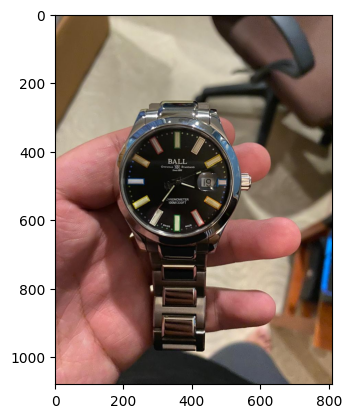

1/1 [==============================] - 0s 43ms/step
Image contains an analogue watch


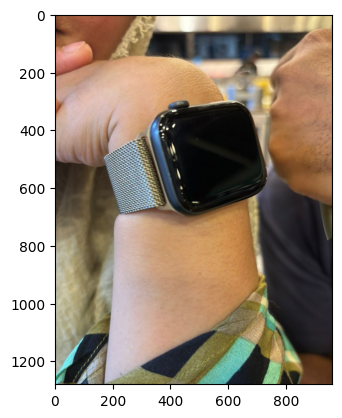

1/1 [==============================] - 0s 13ms/step
Image contains a smart watch


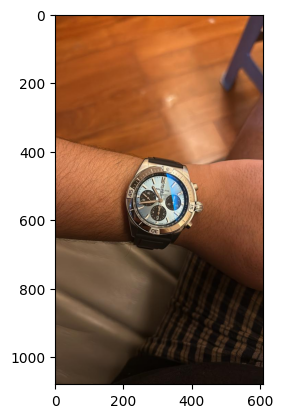

1/1 [==============================] - 0s 12ms/step
Image contains a smart watch


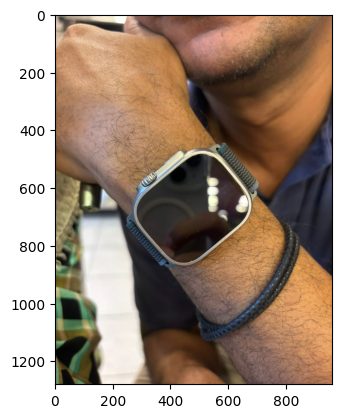

1/1 [==============================] - 0s 16ms/step
Image contains a smart watch


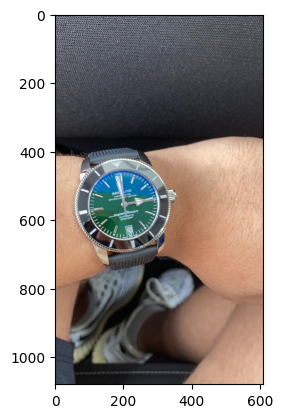

1/1 [==============================] - 0s 12ms/step
Image contains an analogue watch


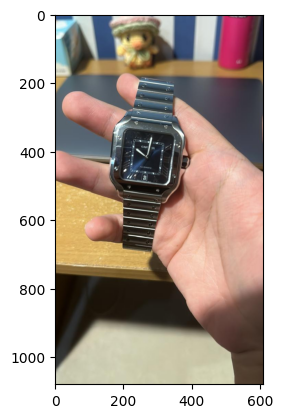

1/1 [==============================] - 0s 13ms/step
Image contains an analogue watch


In [26]:
for image in test_imgs:
    # Display images for reference and resize accordingly (256x256 pixels)
    test_img = cv2.imread(image)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
    plt.show()
    resized_img = tf.image.resize(test_img, (256,256))

    # Predict whether image is label 0 or 1
    ypred = improved_model.predict(np.expand_dims(resized_img/255, 0))

    # Allocate towards label 0 or 1
    if ypred > 0.5:
        print('Image contains a smart watch')
    else:
        print('Image contains an analogue watch')


In [102]:
improved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 59, 59, 32)        16416     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 29, 29, 32)      